In [69]:
# Імпорт необхідних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.dates as mdates

In [70]:
data = pd.read_excel('Офіційний курс гривні щодо іноземних валют.xlsx')
data.head(10)

,Дата,Час,Код цифровий,Код літерний,Кількість одиниць,Назва валюти,"Офіційний курс гривні, грн"
0,01.01.2024,0.0,978,EUR,1,Євро,41.9960
1,02.01.2024,0.0,978,EUR,1,Євро,42.0059
2,03.01.2024,0.0,978,EUR,1,Євро,41.7209
3,04.01.2024,0.0,978,EUR,1,Євро,41.6073
4,05.01.2024,0.0,978,EUR,1,Євро,41.6665
5,06.01.2024,0.0,978,EUR,1,Євро,41.6665
6,07.01.2024,0.0,978,EUR,1,Євро,41.6665
7,08.01.2024,0.0,978,EUR,1,Євро,41.5730
8,09.01.2024,0.0,978,EUR,1,Євро,41.7973
9,10.01.2024,0.0,978,EUR,1,Євро,41.8185


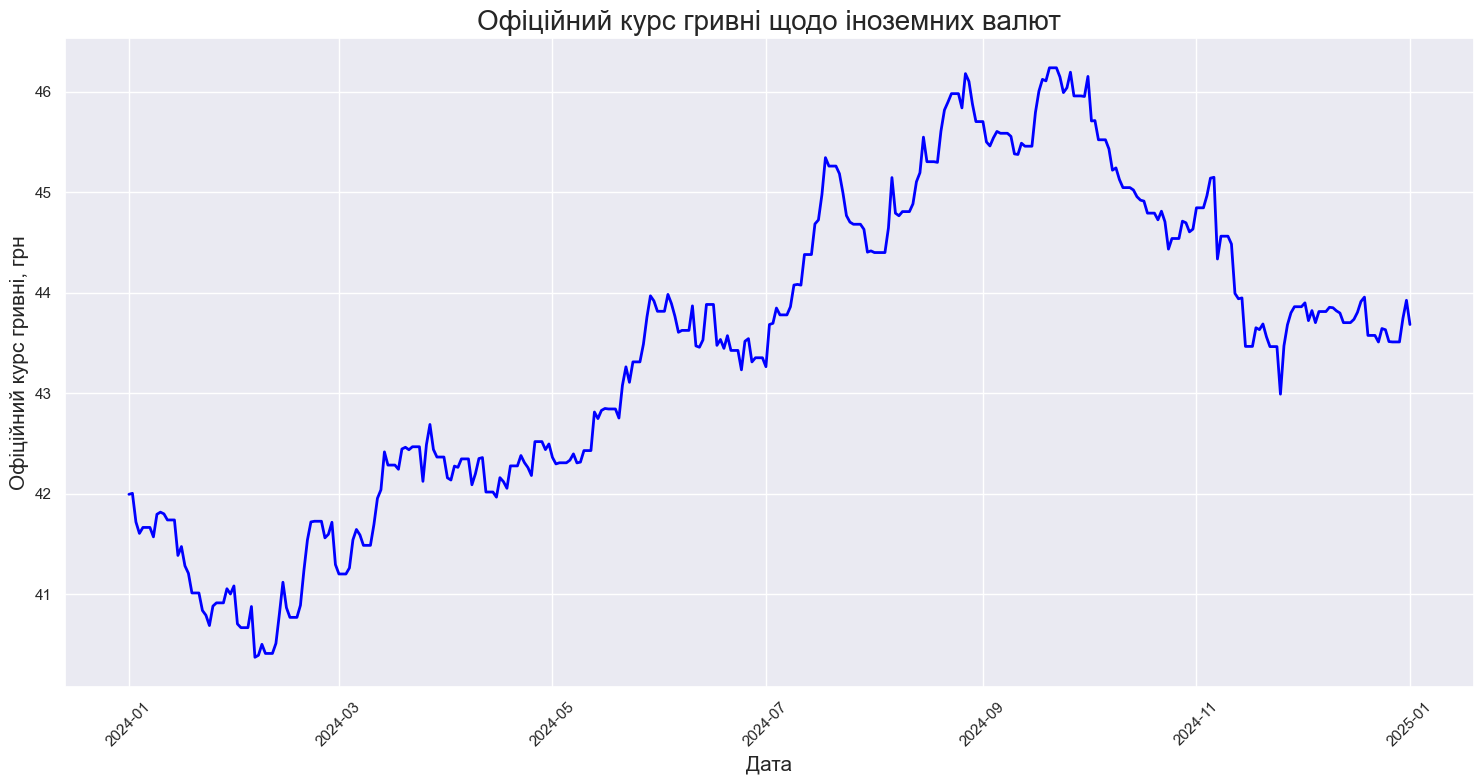

In [71]:
mask = pd.to_datetime(data['Дата'], format='%d.%m.%Y') >= pd.to_datetime('01.01.2024', format='%d.%m.%Y')
data_filtered = data[mask]
data_filtered = data_filtered.drop_duplicates(subset='Дата', keep='first')

date = data_filtered['Дата'].to_numpy()
value = data_filtered['Офіційний курс гривні, грн'].to_numpy()
date = pd.to_datetime(date, format='%d.%m.%Y')


plt.figure(figsize=(15, 8))
plt.plot(date, value, color='blue', linewidth=2)
plt.title('Офіційний курс гривні щодо іноземних валют', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Офіційний курс гривні, грн', fontsize=15)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Best : alpha=0.6000000000000001, beta=0.4, gamma=0.6000000000000001
Best MSE: 0.16430825142594366
Best MAE: 0.3138360547706388


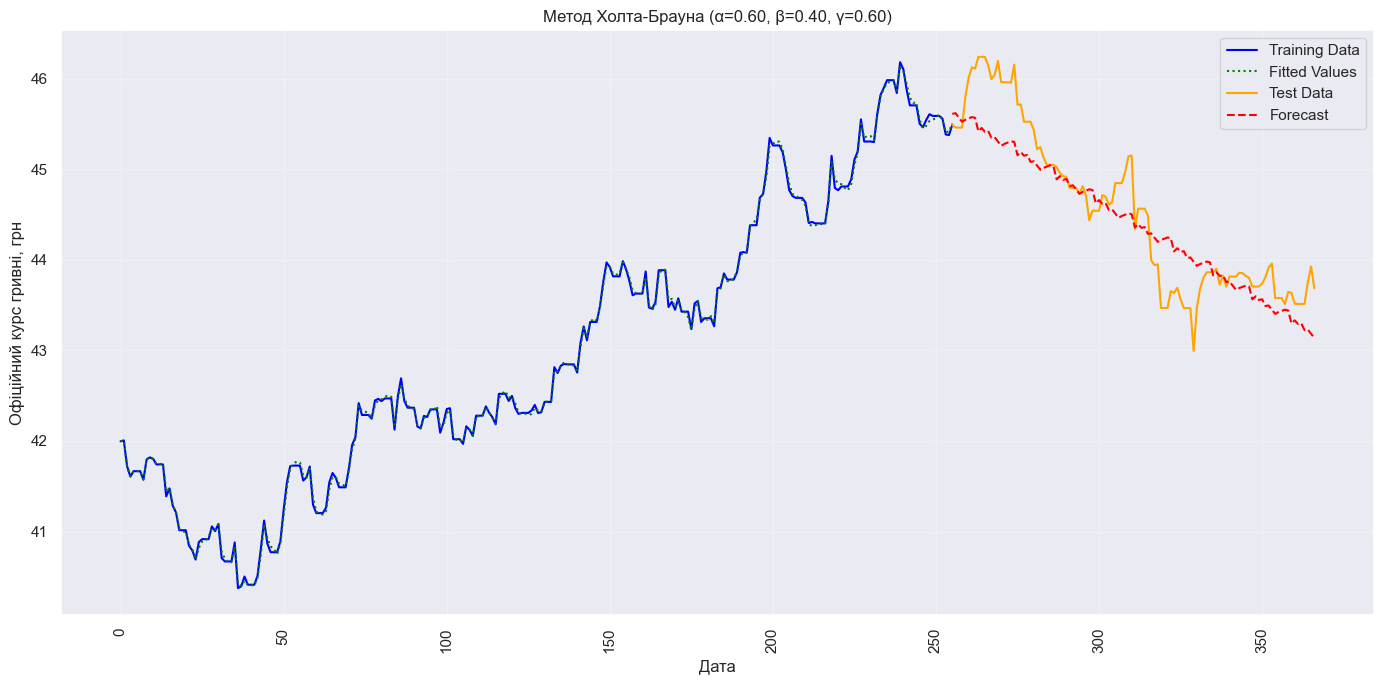


Метрики при тренуванні:
MSE: 0.001090
RMSE: 0.033016
MAE: 0.025317
MAPE: 0.058646

Метрики при прогнозуванні:
MSE: 0.164308
RMSE: 0.405350
MAE: 0.313836
MAPE: 0.701820


In [75]:
def holt_winters_forecast(data, alpha, beta, gamma, seasonal_periods, forecast_periods):
    n = len(data)
    level = np.zeros(n)
    trend = np.zeros(n)
    seasonal = np.zeros(n)

    level[0] = data[0]
    trend[0] = data[1] - data[0]

    season_averages = [np.mean(data[i::seasonal_periods]) for i in range(seasonal_periods)]
    global_average = np.mean(season_averages)
    initial_seasonal = [avg / global_average for avg in season_averages]

    for i in range(seasonal_periods):
        seasonal[i] = initial_seasonal[i % len(initial_seasonal)]

    for i in range(1, n):
        if i >= seasonal_periods:
            level[i] = alpha * (data[i] / seasonal[i - seasonal_periods]) + (1 - alpha) * (level[i - 1] + trend[i - 1])
            trend[i] = beta * (level[i] - level[i - 1]) + (1 - beta) * trend[i - 1]
            seasonal[i] = gamma * (data[i] / level[i]) + (1 - gamma) * seasonal[i - seasonal_periods]
        else:
            level[i] = alpha * data[i] + (1 - alpha) * (level[i - 1] + trend[i - 1])
            trend[i] = beta * (level[i] - level[i - 1]) + (1 - beta) * trend[i - 1]

    fitted_values = np.array([
        level[i] * seasonal[i] if i >= seasonal_periods else data[i]
        for i in range(n)
    ])

    forecast = np.zeros(n + forecast_periods)
    forecast[:n] = fitted_values

    for i in range(n, n + forecast_periods):
        season_idx = (i - seasonal_periods) % seasonal_periods
        forecast[i] = (level[-1] + trend[-1] * (i - n + 1)) * seasonal[season_idx]

    return forecast, fitted_values

def calculate_errors(actual, predicted):
    return {
        'MSE': np.mean((actual - predicted) ** 2),
        'RMSE': np.sqrt(np.mean((actual - predicted) ** 2)),
        'MAE': np.mean(np.abs(actual - predicted)),
        'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100
    }

def plot_forecast_with_fitted(train, test, fitted_values, forecast_values, title="Холт-Браун"):
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train['Офіційний курс гривні, грн'], label='Training Data', color='blue')
    plt.plot(train.index, fitted_values, label='Fitted Values', color='green', linestyle=':')
    plt.plot(test.index, test['Офіційний курс гривні, грн'], label='Test Data', color='orange')
    plt.plot(test.index, forecast_values[len(train):], label='Forecast', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Офіційний курс гривні, грн')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Підготовка даних
train_len = int(len(data_filtered) * 0.7)
train = data_filtered.iloc[:train_len].copy()
test = data_filtered.iloc[train_len - 1:].copy()

train['Дата'] = pd.to_datetime(train['Дата'], format='%d.%m.%Y')
test['Дата'] = pd.to_datetime(test['Дата'], format='%d.%m.%Y')

train['Офіційний курс гривні, грн'] = train['Офіційний курс гривні, грн'].astype(float)
test['Офіційний курс гривні, грн'] = test['Офіційний курс гривні, грн'].astype(float)

train_data = train['Офіційний курс гривні, грн'].to_numpy()
test_data = test['Офіційний курс гривні, грн'].to_numpy()

# Підбір найкращих параметрів
best_params = {'alpha': 0, 'beta': 0, 'gamma': 0}
best_mse = float('inf')
best_mae = float('inf')

for alpha in np.arange(0.1, 1.0, 0.1):
    for beta in np.arange(0.1, 1.0, 0.1):
        for gamma in np.arange(0.1, 1.0, 0.1):
            forecast, fitted_values = holt_winters_forecast(
                train_data, alpha, beta, gamma,
                seasonal_periods=12, forecast_periods=len(test_data)
            )

            mae = np.mean(np.abs(forecast[len(train_data):] - test_data))
            mse = np.mean((forecast[len(train_data):] - test_data) ** 2)

            if mse < best_mse:
                best_mse = mse
                best_mae = mae
                best_params = {'alpha': alpha, 'beta': beta, 'gamma': gamma}

print(f"Best : alpha={best_params['alpha']}, beta={best_params['beta']}, gamma={best_params['gamma']}")
print(f"Best MSE: {best_mse}")
print(f"Best MAE: {best_mae}")

# Прогнозування з найкращими параметрами
forecast, fitted_values = holt_winters_forecast(
    train_data,
    alpha=best_params['alpha'],
    beta=best_params['beta'],
    gamma=best_params['gamma'],
    seasonal_periods=12,
    forecast_periods=len(test_data)
)

plot_forecast_with_fitted(
    train, test, fitted_values, forecast,
    title=f"Метод Холта-Брауна (α={best_params['alpha']:.2f}, β={best_params['beta']:.2f}, γ={best_params['gamma']:.2f})"
)

train_errors = calculate_errors(train_data, fitted_values)
forecast_errors = calculate_errors(test_data, forecast[len(train_data):])

print("\nМетрики при тренуванні:")
for metric, value in train_errors.items():
    print(f"{metric}: {value:.6f}")

print("\nМетрики при прогнозуванні:")
for metric, value in forecast_errors.items():
    print(f"{metric}: {value:.6f}")
